# Coursera Capstone Final Project

## Project Description

The goal for the project is to find the best place in Budapest for a new pub. It is crucial to find the right location for businesses, most of the time it is the deciding factor in the beginning of the business.

I will use the Foursquare API to solve the problem. To find the best place it`s important to find the already existing places, which places are popular and if is there any room for a new business.

There are also regulations where you can open a pub, in our case it has to be at least 150 meters from any public school.

In [357]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import re
import geopy.distance
import pickle
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from collections import OrderedDict
from operator import itemgetter 

In [4]:
# Function for parsing url, I needed to add the header because some websites are checking the browser for the get queries
def parse(url):
    headers = {'User-Agent': 'Mozilla/5.0'}
    return requests.get(url, headers=headers).content

This page contains all the gps coordinates for the districts: http://nepesseg.com/budapest/
In this function I will parse the data:

In [5]:
def parseDistricts(num):
    url = "http://nepesseg.com/budapest/budapest-{:02d}-kerulet".format(num)
    content = parse(url)
    soup = BeautifulSoup(content, "lxml")
    tag = soup.find(lambda tag:tag.name=="p" and "GPS koordinátái:" in tag.text)
    arr = re.findall(r"[-+]?\d*\.\d+|\d+", tag.text)
    return (arr[-2], arr[-1])

Get the coordinates for all the 23 districts in Budapest

In [6]:
budapest_coord = []
for i in range(1,24):
    coord = parseDistricts(i)
    budapest_coord.append(("Budapest " + str(i), float(coord[0]), float(coord[1])))

Checking the coordinates

In [7]:
budapest_coord

[('Budapest 1', 47.4968, 19.0375),
 ('Budapest 2', 47.5393, 18.9869),
 ('Budapest 3', 47.5672, 19.0369),
 ('Budapest 4', 47.5778, 19.0952),
 ('Budapest 5', 47.5002, 19.052),
 ('Budapest 6', 47.5081, 19.0678),
 ('Budapest 7', 47.5027, 19.0734),
 ('Budapest 8', 47.4887, 19.0845),
 ('Budapest 9', 47.4649, 19.0916),
 ('Budapest 10', 47.4821, 19.1575),
 ('Budapest 11', 47.4593, 19.0187),
 ('Budapest 12', 47.4991, 18.9905),
 ('Budapest 13', 47.5355, 19.0709),
 ('Budapest 14', 47.5225, 19.1147),
 ('Budapest 15', 47.5627, 19.1325),
 ('Budapest 16', 47.5183, 19.1919),
 ('Budapest 17', 47.4754, 19.2665),
 ('Budapest 18', 47.4281, 19.2098),
 ('Budapest 19', 47.4457, 19.143),
 ('Budapest 20', 47.4333, 19.1193),
 ('Budapest 21', 47.4244, 19.0661),
 ('Budapest 22', 47.4105, 19.0001),
 ('Budapest 23', 47.394, 19.1225)]

In [8]:
budapest_data = pd.DataFrame(list(budapest_coord), columns=['District', 'Latitude', 'Longitude'])

In [9]:
latitude = 47.50
longitude = 19.05

In [10]:
# create map of Manhattan using latitude and longitude values
map_budapest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(budapest_data['Latitude'], budapest_data['Longitude'], budapest_data['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_budapest)  
    
map_budapest

In [11]:

coords_1 = (47.4968, 19.0375)
coords_2 = (47.5393, 18.9869)

print(geopy.distance.vincenty(coords_1, coords_2).km)

6.070562527719248


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  """


In [12]:
CLIENT_ID = 'N3WFOT4ZNN400G3S3MD23HOSCMOLSY4IGXLEMDX4O0K5NEWC' # your Foursquare ID
CLIENT_SECRET = 'WJYGOWE2B5KPY30LFQ20IYVJ522BLYLAZRCPNMBJQZLRDFZT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N3WFOT4ZNN400G3S3MD23HOSCMOLSY4IGXLEMDX4O0K5NEWC
CLIENT_SECRET:WJYGOWE2B5KPY30LFQ20IYVJ522BLYLAZRCPNMBJQZLRDFZT


In [13]:
neighborhood_latitude = budapest_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = budapest_data.loc[0, 'Longitude'] # neighborhood longitude value

In [14]:
LIMIT = 100 
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c4c5f574434b97443db341e'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bc9f998937ca59338c2a692-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
          'suffix': '.png'},
         'id': '50aaa49e4b90af0d42d5de11',
         'name': 'Castle',
         'pluralName': 'Castles',
         'primary': True,
         'shortName': 'Castle'}],
       'id': '4bc9f998937ca59338c2a692',
       'location': {'address': 'Budai Vár',
        'cc': 'HU',
        'city': 'Budapest',
        'country': 'Magyarország',
        'distance': 167,
        'formattedAddress': ['Budapest', 'Budai Vár', '1014', 'Magyarország'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 47.496197815204255,
          'lng': 19.0

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    LIMIT = 50
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        res_json = requests.get(url).json()
        if "response" in res_json:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        else:
            venues_list.append([(
            '',
            name, 
            lat, 
            lng, 
            '', 
            0, 
            0,  
            '')])
            continue
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            v['venue']['id'], 
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Id', 
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
budapest_venues = getNearbyVenues(names=budapest_data['District'],
                                   latitudes=budapest_data['Latitude'],
                                   longitudes=budapest_data['Longitude']
                                  )

Budapest 1
Budapest 2
Budapest 3
Budapest 4
Budapest 5
Budapest 6
Budapest 7
Budapest 8
Budapest 9
Budapest 10
Budapest 11
Budapest 12
Budapest 13
Budapest 14
Budapest 15
Budapest 16
Budapest 17
Budapest 18
Budapest 19
Budapest 20
Budapest 21
Budapest 22
Budapest 23


In [18]:
budapest_venues.groupby('Neighborhood').count()

Id  Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                              
Budapest 1    100                    100                     100    100   
Budapest 10    23                     23                      23     23   
Budapest 11    55                     55                      55     55   
Budapest 12    33                     33                      33     33   
Budapest 13    95                     95                      95     95   
Budapest 14    63                     63                      63     63   
Budapest 15    31                     31                      31     31   
Budapest 16    27                     27                      27     27   
Budapest 17    20                     20                      20     20   
Budapest 18    26                     26                      26     26   
Budapest 19    26                     26                      26     26   
Budapest 2     17                     17                      17     17   
Budapest 20    33                     33                      33     33   
Budapest 21    35                     35                      35     35   
Budapest 22    12                     12                      12     12   
Budapest 23    17                     17                      17     17   
Budapest 3     23                     23                      23     23   
Budapest 4     40                     40                      40     40   
Budapest 5    100                    100                     100    100   
Budapest 6    100                    100                     100    100   
Budapest 7    100                    100                     100    100   
Budapest 8    100                    100                     100    100   
Budapest 9     31                     31                      31     31   

              Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                   
Budapest 1               100              100             100  
Budapest 10               23               23              23  
Budapest 11               55               55              55  
Budapest 12               33               33              33  
Budapest 13               95               95              95  
Budapest 14               63               63              63  
Budapest 15               31               31              31  
Budapest 16               27               27              27  
Budapest 17               20               20              20  
Budapest 18               26               26              26  
Budapest 19               26               26              26  
Budapest 2                17               17              17  
Budapest 20               33               33              33  
Budapest 21               35               35              35  
Budapest 22               12               12              12  
Budapest 23               17               17              17  
Budapest 3                23               23              23  
Budapest 4                40               40              40  
Budapest 5               100              100             100  
Budapest 6               100              100             100  
Budapest 7               100              100             100  
Budapest 8               100              100             100  
Budapest 9                31               31              31

Let`s search for similar categories:

In [19]:
budapest_pubs = budapest_venues[(budapest_venues['Venue Category'] == 'Beer Bar') | 
                (budapest_venues['Venue Category'] == 'Bistro') | 
                (budapest_venues['Venue Category'] == 'Bar') | 
                (budapest_venues['Venue Category'] == 'Karaoke Bar') | 
                (budapest_venues['Venue Category'] == 'Gastropub') | 
                (budapest_venues['Venue Category'] == 'Cocktail Bar') | 
                (budapest_venues['Venue Category'] == 'Beer Garden') | 
                (budapest_venues['Venue Category'] == 'Brewery') | 
               (budapest_venues['Venue Category'] == 'Pub')]

We can see the distribution of these categories:

In [26]:
budapest_pubs.groupby('Venue Category').count()['Id']

Venue Category
Bar             22
Beer Bar         7
Beer Garden      4
Bistro           9
Brewery          3
Cocktail Bar     3
Gastropub        6
Karaoke Bar      1
Pub             24
Name: Id, dtype: int64

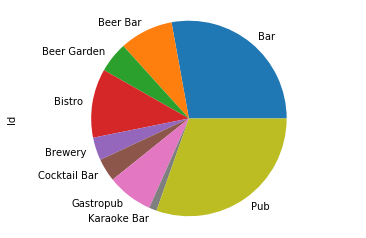

In [29]:
budapest_pubs.groupby('Venue Category').count()['Id'].plot(kind='pie')
plt.axis('equal')
plt.show()

It can be useful to check how many venues of this type are in each distict:

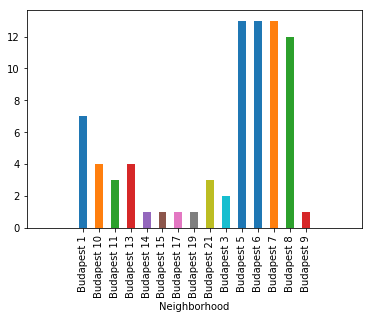

In [31]:
budapest_pubs.groupby('Neighborhood').count()['Id'].plot(kind='bar')
plt.axis('equal')
plt.show()

In [52]:
#Function to get venue details
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION
    )
    return requests.get(url).json()

In [53]:
#Check if response was successful
def checkResponses(responses):
    if len(responses)==0:
        return False
    for response in responses:
        code = response['meta']['code']
        if code != 200:
            return False
    return True

In [54]:
#Load from api if pickle was not successful
def loadDetailsWithFilter(districtNum):
    pub_details = []
    for pub_id in budapest_pubs[budapest_pubs['Neighborhood'] == 'Budapest {}'.format(districtNum)]['Id']:
        json = get_venue_details(pub_id) 
        pub_details.append(json)
    pickle.dump( pub_details, open( "pub_details_{}.p".format(districtNum), "wb" ) )
    return pub_details

## Get all the pub details from the districts

In [55]:
def loadPickle(filename):
    try:
        return pickle.load(open(filename, "rb"))
    except (OSError, IOError) as e:
        return []

In [56]:
pub_details_5 = loadPickle( "pub_details_5.p")
if not(checkResponses(pub_details_5)):
    pub_details_5 = loadDetailsWithFilter(5)
pub_details_6 = loadPickle( "pub_details_6.p")
if not(checkResponses(pub_details_6)):
    pub_details_6 = loadDetailsWithFilter(6)
pub_details_7 = loadPickle( "pub_details_7.p")
if not(checkResponses(pub_details_7)):
    pub_details_7 = loadDetailsWithFilter(7)
pub_details_8 = loadPickle( "pub_details_8.p")
if not(checkResponses(pub_details_8)):
    pub_details_8 = loadDetailsWithFilter(8)
pub_details_1 = loadPickle( "pub_details_1.p")
if not(checkResponses(pub_details_1)):
    pub_details_1 = loadDetailsWithFilter(1)

In [58]:
def getDetail(detail, key):
    if key in detail:
        return detail[key]
    return 'Unknown'

def getPrice(detail):
    price = getDetail(venue, 'price')
    if getDetail(venue, 'price') != 'Unknown':
        return price['tier']
    return -1

def getAttributes(venue):
    result = dict()
    for group in venue["attributes"]["groups"]:
        key = group["items"][0]["displayName"]
        val = group["items"][0]["displayValue"]
        result[key] = val
    return result

def getPostalCode(venue):
    location = getDetail(venue, 'location')
    if 'postalCode' in location:
        return location['postalCode']
    return 9999

def getNumberOfLikes(venue):
    location = getDetail(venue, 'likes')
    if 'count' in location:
        return location['count']
    return 0

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [103]:
merged_pub_details = pub_details_1 + pub_details_5 + pub_details_6 + pub_details_7 + pub_details_8
venues_data = []
for detail in merged_pub_details:
    if 'venue'not in detail['response']:
        print(detail['response'])
        continue
    venue = detail['response']['venue']
    name = getDetail(venue, 'name')
    rating = getDetail(venue, 'rating')
    price = getPrice(venue)
    postal_code = getPostalCode(venue)
    likes = getNumberOfLikes(venue)
    attributes = getAttributes(venue)
    venue_dict = {
        'Name': name,
        'Rating': rating,
        'PriceRate' : price,
        'PostalCode' : postal_code,
        'Likes' : likes
    }
    venue_merged = merge_two_dicts(venue_dict, attributes)
    venues_data.append(venue_merged)
venue_df = pd.DataFrame(venues_data) 

#reorder columns
cols = []
non_null_columns = [col for col in venue_df.columns if not(venue_df[col].isnull().any())]
cols.extend(non_null_columns)
cols.extend([x for x in venue_df.columns if x not in non_null_columns])
#venue_df = venue_df[cols]
venue_df = venue_df[cols].drop_duplicates()

In [104]:
#Check most popular pubs
venue_df.sort_values(['Likes'], ascending=[0])

Likes                                         Name PostalCode  PriceRate  \
1     581                               Déryné Bisztró       1013          2   
26    576                        Kandalló Kézműves Pub       1073          2   
34    575                        Kandalló Kézműves Pub       1073          2   
27    486                                      360 Bar       1061          3   
43    482                               STIKA Budapest       1072          2   
48    456                                      A Grund       1082          2   
42    430                                      Kisüzem       1077          2   
16    412                     Telep Art Bar and Bistro       1075          2   
7     376                                    Borkonyha       1051         -1   
9     369                                   Boutiq'Bar       1061          2   
17    335                                   Toldi Klub       1054          2   
24    299                                 Kiadó Kocsma       1061          2   
6     291                                          MÁK       1051          2   
25    261                               Csak a jó sör!       1073          2   
2     222                                 Belga Söröző       1011          1   
8     171                                     Café Kör       1051          3   
38    152                  Hopaholic - In Hop We Trust       1072         -1   
44    148                                       WarmUp       1077          3   
28    145   The Caledonia Budapest Scottish Pub & Shop       1066          2   
18    142                               Hivatal Kávézó       1075          2   
12    138                               Cech In Sörtár       1065          2   
46    135  Gólya Közösségi Ház és Szövetkezeti Presszó       1083          1   
29    132                                      Fricska       1073          3   
31    130                                     Pótkulcs       9999          1   
20    124                   Snaps Galéria Belga Söröző       1071          2   
0     115                 Pater Marcus Apátsági Söröző       1011          1   
51    100                        OINOS WineBar&Bistrot       1084          2   
5      99                      Dunaparti Matróz Kocsma       1011          1   
45     92                               Hintaló Iszoda       1084          2   
22     83              Ferdinánd Monarchia Cseh Sörház       1067          1   
56     72                                   Andersen 2       1082          2   
13     68                                  Bistro Fine       1061         -1   
40     65                                   Beer Point       1073         -1   
15     63                                  Tuk Tuk Bar       1061          3   
30     54                              Wunder Sörművek       1066         -1   
49     50                                       Kék Ló       1084          1   
19     42                               Lakatos Műhely       9999          3   
37     39                               Kalicka Bistro       1074          2   
3      36                         Hunyadi Lakásbisztró       1011          2   
52     35                                 Bujdosó Kert       1082          1   
54     30                               Bohemia Söröző       1084          1   
23     26                    Jaromír '68 Cseh Sörpince       1067          1   
4      26                           Mr&Mrs Columbo Pub       1013          1   
53     23                             Neked Csak Nyolc       1082         -1   
21     22                                   Ogre Bácsi       1067          2   
32     20                                Refuge Bistro       1073          2   
14     19                                  Game Up Pub       9999          2   
50     13                                    Vödör bar       9999          2   
10     13                                        Hedon       1051         -1   
57  

In [105]:
# Check average likes by postal code
venue_df.groupby('PostalCode')['Rating', 'Likes'].agg(np.mean)

Rating       Likes
PostalCode                      
9999        8.300000   51.000000
1011        8.125000  118.000000
1013        8.200000  303.500000
1051        8.600000  212.750000
1054        8.300000  335.000000
1061        8.680000  257.000000
1065        8.600000  138.000000
1066        8.350000   99.500000
1067        7.833333   43.666667
1071        8.400000  124.000000
1072        8.400000  317.000000
1073        8.616667  271.500000
1074        7.400000   39.000000
1075        8.650000  277.000000
1077        8.850000  289.000000
1082        7.125000  146.500000
1083        8.050000   72.500000
1084        8.175000   68.000000
1091        5.700000   12.000000
1096        6.400000   11.000000

(5, 9)

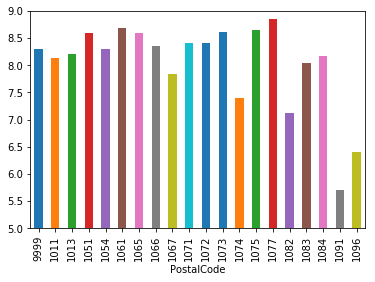

In [106]:
venue_df.groupby('PostalCode')['Rating'].agg(np.mean).plot(kind='bar')
plt.ylim(ymin=5, ymax=9, bottom=6)  # this line

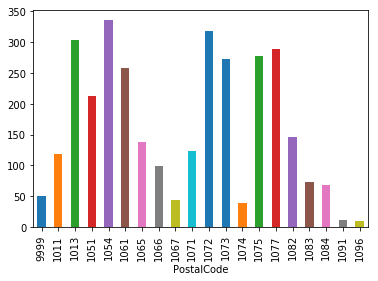

In [107]:
venue_df.groupby('PostalCode')['Likes'].agg(np.mean).plot(kind='bar')

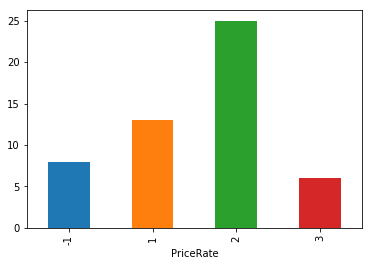

In [108]:
venue_df.groupby('PriceRate')['Name'].count().plot(kind='bar')

We can see that the price rate directly affects the ratings

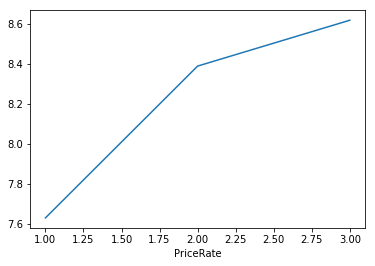

In [323]:
venue_df.groupby('PriceRate')['Rating'].agg(np.mean)[[1,2,3]].plot(kind='line')

## Data preprocessing

True or false values must be converted

In [110]:
for col in venue_df.columns:
    print(col)
    if isinstance(col, str) and venue_df[col].dtype == 'object': 
        venue_df.loc[venue_df[col] == col, col] = True
        venue_df.loc[venue_df[col] == 'Yes', col] = True
        venue_df.loc[venue_df[col] == 'No', col] = False
        

Likes
Name
PostalCode
PriceRate
Rating
Bar Service
Beer
Breakfast
Brunch
Cocktails
Credit Cards
Delivery
Dinner
Full Bar
Groups Only
Happy Hour
Jukebox
Live Music
Lunch
Music
Outdoor Seating
Price
Private Room
Reservations
Restroom
Smoking
Street Parking
TVs
Table Service
Wheelchair Accessible
Wi-Fi
Wine


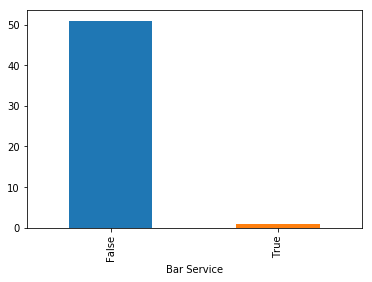

In [111]:
column = 'Bar Service'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

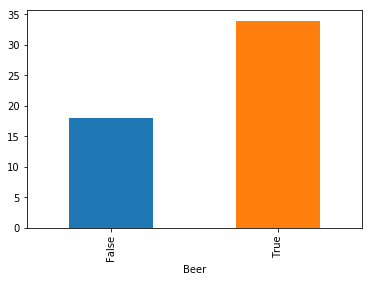

In [112]:
column = 'Beer'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

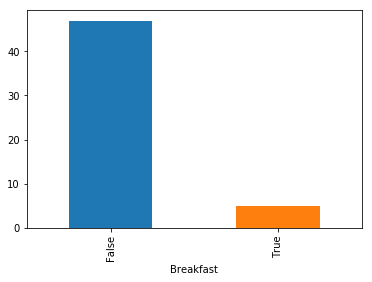

In [113]:
column = 'Breakfast'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

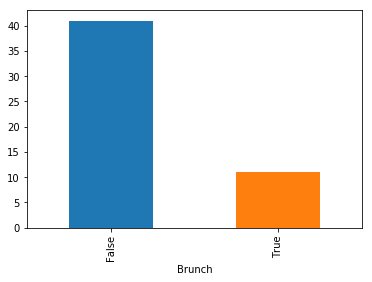

In [114]:
column = 'Brunch'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

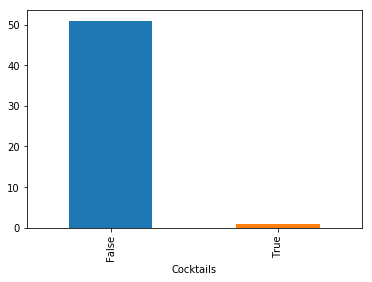

In [115]:
column = 'Cocktails'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

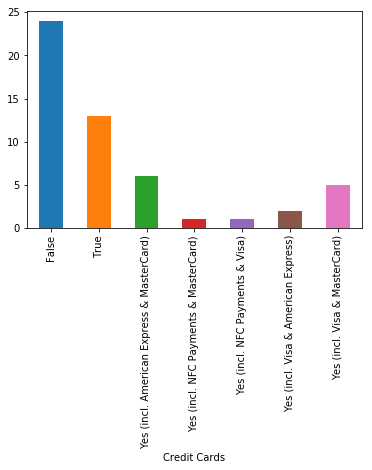

In [116]:
column = 'Credit Cards'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

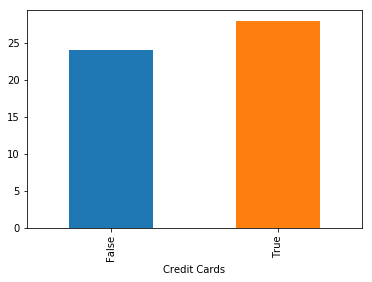

In [120]:
# There are different true values for credit card payment
venue_df.loc[venue_df[column] == 'Yes (incl. American Express & MasterCard)', column] = True
venue_df.loc[venue_df[column] == 'Yes (incl. Visa & MasterCard)', column] = True
venue_df.loc[venue_df[column] == 'Yes (incl. NFC Payments & MasterCard)', column] = True
venue_df.loc[venue_df[column] == 'Yes (incl. NFC Payments & Visa)', column] = True
venue_df.loc[venue_df[column] == 'Yes (incl. Visa & American Express)', column] = True
venue_df.groupby(column)['Name'].count().plot(kind='bar')

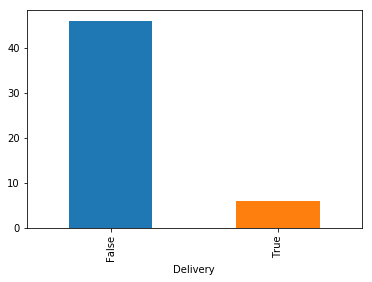

In [123]:
column = 'Delivery'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.loc[venue_df[column] == 'No Delivery', column] = False
venue_df.groupby(column)['Name'].count().plot(kind='bar')

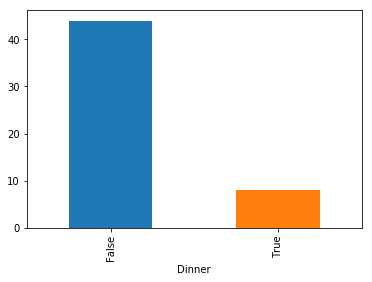

In [125]:
column = 'Dinner'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

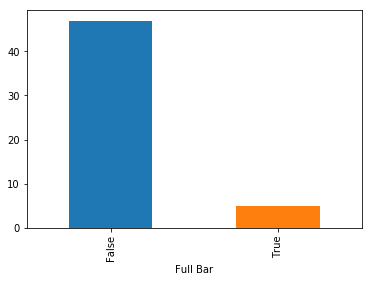

In [126]:
column = 'Full Bar'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

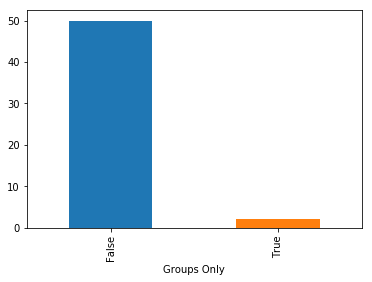

In [128]:
column = 'Groups Only'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

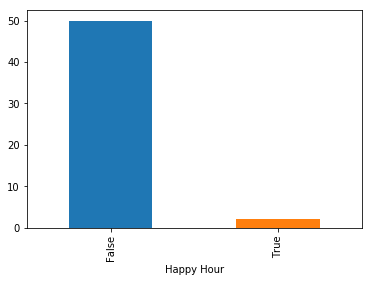

In [129]:
column = 'Happy Hour'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

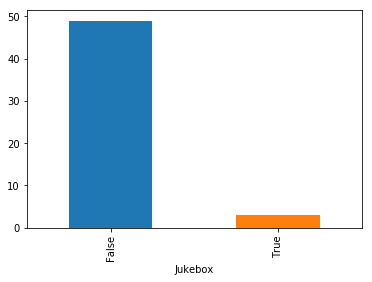

In [130]:
column = 'Jukebox'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

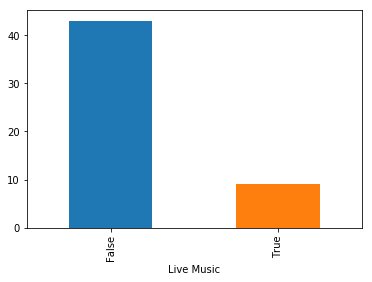

In [131]:
column = 'Live Music'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

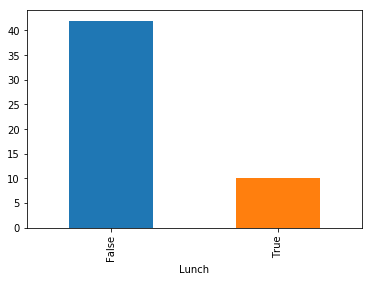

In [132]:
column = 'Lunch'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

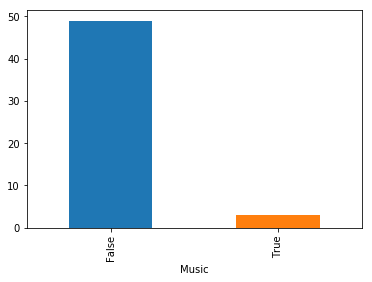

In [133]:
column = 'Music'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

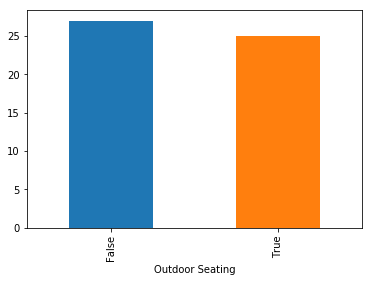

In [134]:
column = 'Outdoor Seating'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

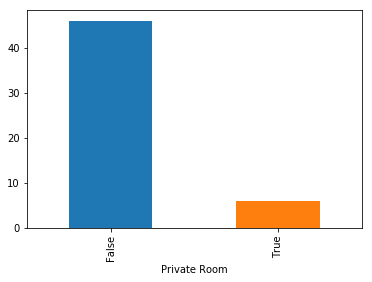

In [136]:
column = 'Private Room'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

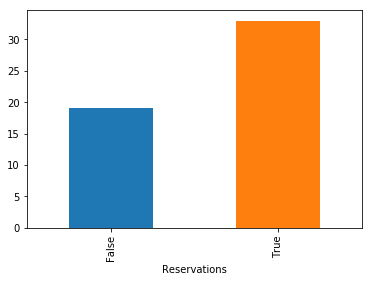

In [138]:
column = 'Reservations'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

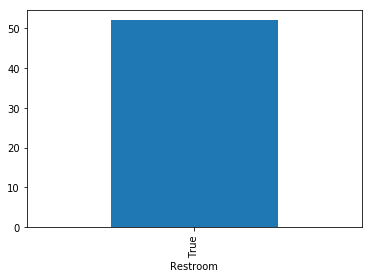

In [139]:
column = 'Restroom'
venue_df[[column]] = venue_df[[column]].fillna(value=True)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

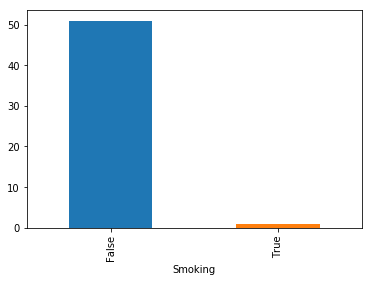

In [140]:
column = 'Smoking'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

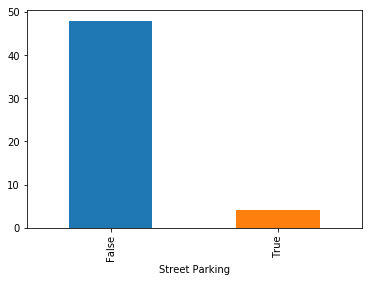

In [141]:
column = 'Street Parking'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.loc[venue_df[column] == 'Street', column] = True
venue_df.groupby(column)['Name'].count().plot(kind='bar')

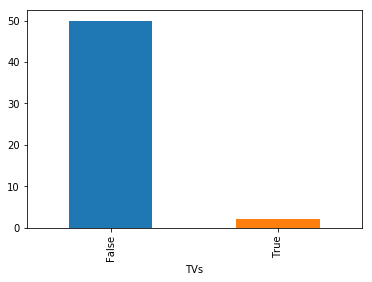

In [142]:
column = 'TVs'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

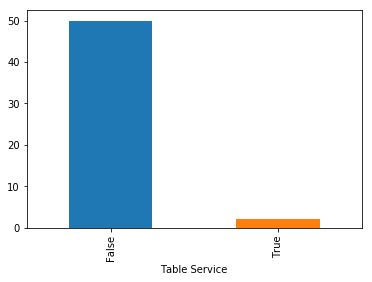

In [143]:
column = 'Table Service'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

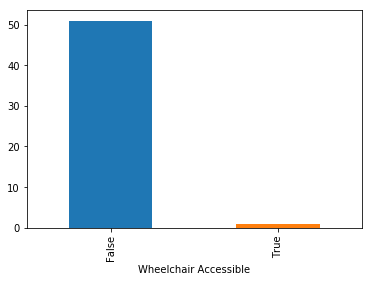

In [144]:
column = 'Wheelchair Accessible'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

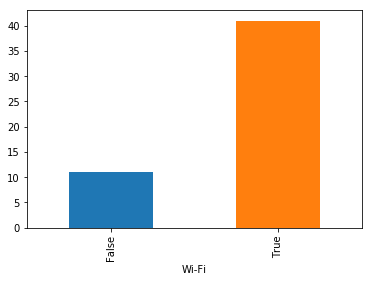

In [146]:
column = 'Wi-Fi'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.loc[venue_df[column] == 'Free', column] = True
venue_df.groupby(column)['Name'].count().plot(kind='bar')

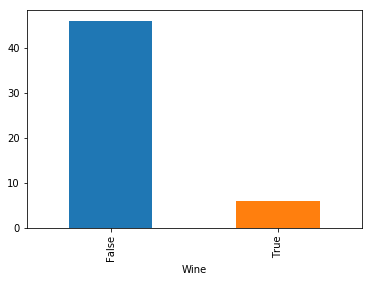

In [147]:
column = 'Wine'
venue_df[[column]] = venue_df[[column]].fillna(value=False)
venue_df.groupby(column)['Name'].count().plot(kind='bar')

In [375]:
# Check the result of the conversion
from IPython.display import display
pd.options.display.max_columns = None

venue_df

Likes                                         Name PostalCode  PriceRate  \
0     115                 Pater Marcus Apátsági Söröző       1011          1   
1     581                               Déryné Bisztró       1013          2   
2     222                                 Belga Söröző       1011          1   
3      36                         Hunyadi Lakásbisztró       1011          2   
4      26                           Mr&Mrs Columbo Pub       1013          1   
5      99                      Dunaparti Matróz Kocsma       1011          1   
6     291                                          MÁK       1051          2   
7     376                                    Borkonyha       1051         -1   
8     171                                     Café Kör       1051          3   
9     369                                   Boutiq'Bar       1061          2   
10     13                                        Hedon       1051         -1   
12    138                               Cech In Sörtár       1065          2   
13     68                                  Bistro Fine       1061         -1   
14     19                                  Game Up Pub       9999          2   
15     63                                  Tuk Tuk Bar       1061          3   
16    412                     Telep Art Bar and Bistro       1075          2   
17    335                                   Toldi Klub       1054          2   
18    142                               Hivatal Kávézó       1075          2   
19     42                               Lakatos Műhely       9999          3   
20    124                   Snaps Galéria Belga Söröző       1071          2   
21     22                                   Ogre Bácsi       1067          2   
22     83              Ferdinánd Monarchia Cseh Sörház       1067          1   
23     26                    Jaromír '68 Cseh Sörpince       1067          1   
24    299                                 Kiadó Kocsma       1061          2   
25    261                               Csak a jó sör!       1073          2   
26    576                        Kandalló Kézműves Pub       1073          2   
27    486                                      360 Bar       1061          3   
28    145   The Caledonia Budapest Scottish Pub & Shop       1066          2   
29    132                                      Fricska       1073          3   
30     54                              Wunder Sörművek       1066         -1   
31    130                                     Pótkulcs       9999          1   
32     20                                Refuge Bistro       1073          2   
34    575                        Kandalló Kézműves Pub       1073          2   
37     39                               Kalicka Bistro       1074          2   
38    152                  Hopaholic - In Hop We Trust       1072         -1   
40     65                                   Beer Point       1073         -1   
42    430                                      Kisüzem       1077          2   
43    482                               STIKA Budapest       1072          2   
44    148                                       WarmUp       1077          3   
45     92                               Hintaló Iszoda       1084          2   
46    135  Gólya Közösségi Ház és Szövetkezeti Presszó       1083          1   
47     10                               Dagoba-bisztró       1083         -1   
48    456                                      A Grund       1082          2   
49     50                                       Kék Ló       1084          1   
50     13                                    Vödör bar       9999          2   
51    100                        OINOS WineBar&Bistrot       1084          2   
52     35                                 Bujdosó Kert       1082          1   
53     23                             Neked Csak Nyolc       1082         -1   
54     30                               Bohemia Söröző       1084          1   
55  

## Show venues on Map

In [151]:
budapest_other_venues = pd.concat([budapest_pubs, budapest_venues]).drop_duplicates(keep=False)

In [152]:
budapest_pubs_merged = budapest_pubs.set_index('Venue').join(venue_df[['Name', 'PriceRate', 'Rating']].set_index('Name'))

In [153]:
budapest_pubs_merged

Id  \
360 Bar                                      5374ddf2498e43fccfbc5e89   
A Grund                                      4b8c2928f964a5206fc132e3   
Andersen 2                                   4ff756c6e4b01ead0237222c   
B.A.K. Hütte                                 4ffb2f30e4b08a4c7447bf45   
Beer Point                                   585478220a3d5419757ae1ea   
Belga Söröző                                 4c90fbf151d9b1f72bae7c46   
Bistro Fine                                  56e1c416498efa4a84d3be51   
Bohemia Söröző                               4ee3bea5e5faffd730fe5610   
Bohém Söröző                                 4be6c1aa477d9c74fdc8e62d   
Borkonyha                                    4d6ea7152427224ba39ad04d   
Boutiq'Bar                                   4b7f0134f964a520ae0f30e3   
Bujdosó Kert                                 4dceccab1f6eb1227084344b   
Café Kör                                     4b7d9c72f964a520a5c92fe3   
Cech In Sörtár                               5060a13d498efd4a9c7eb5c7   
Csak a jó sör!                               4d137b5bffa1224b88d3a0ad   
Csak a jó sör!                               4d137b5bffa1224b88d3a0ad   
Csősztorony Bisztró                          50003e2fe4b0d03187acfae3   
Dagoba-bisztró                               5a6f168ff193c029b1bc47db   
Dunaparti Matróz Kocsma                      4ba383e1f964a520864338e3   
Déryné Bisztró                               4c5fba3bb36eb713f8049ad2   
Faház Drinkbár                               4f0c2a4ee4b03e74957b8f9c   
Fehér Nyúl Sörfőzde                          58bc376d7ff1e457a769b36b   
Ferdinánd Monarchia Cseh Sörház              4beaf932a9900f4756331740   
Fricska                                      54838153498e8cea44a5d027   
Fricska                                      54838153498e8cea44a5d027   
Game Up Pub                                  571d2848498e92ae04e54fc9   
Guriga söröző                                4ff04485e4b01885360aae7f   
Gólya Közösségi Ház és Szövetkezeti Presszó  5239872e049343e2c63bf717   
HaBár                                        521cd5fa11d2dd6ae1b59f2b   
Hedon                                        5b33c92fcd441c002c84bbeb   
...                                                               ...   
MÁK                                          4bdc70b0c79cc928af8d86e9   
MÁK                                          4bdc70b0c79cc928af8d86e9   
Márton Pince Söröző                          4da088bdb787a1cdc32e8310   
Neked Csak Nyolc                             573333d8498eb7eba6992a9c   
OINOS WineBar&Bistrot                        53ef6995498e52a63d30e972   
Ogre Bácsi                                   57e4191d498e992e0a20d5b3   
Ogre Bácsi                                   57e4191d498e992e0a20d5b3   
Patak                                        4d4c7952e4fd6ea8d9efc361   
Pater Marcus Apátsági Söröző                 4c24f4dff7ced13a74b6236d   
Pocok Presszó                                4d83e58550913704177b735b   
Pók Cafe                                     4cddc9b33644a0937df1479f   
Pók Roulette Cafe                            4dc455adc65b89d3ca521d0b   
Pótkulcs                                     4b7c1c56f964a520897d2fe3   
Refuge Bistro                                587ab4e36d349d17a0a46865   
Refuge Bistro                                587ab4e36d349d17a0a46865   
Retro Kert & Coffee                          4d94b602cf46224b5f4a9b94   
Rizmajer Kézműves Sörház                     4fd5dbd4e4b0d6a97e064fa9   
Rudolf borozó                                4d435daa59ca2d43d3cb120f   
STIKA Budapest                               53ef9f36498e0f7e44dedd17   
Scarabeus Music Cafe                         4d3ca6e26b3d236aeffd6264   
Snaps Galéria Belga Söröző                   4be992a362c0c92867ccdfd4   
Snaps Galéria Belga Söröző                   4be992a362c0c92867ccdfd4   
Telep Art Bar and Bistro                     4dda90141838b8561d330b0e   
The Caledonia Budapest Scottish Pub & Shop   4b5b4a7

In [154]:
# create map of Budapest using latitude and longitude values
pub_budapest_inner = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, rating in zip(budapest_pubs_merged['Venue Latitude'], budapest_pubs_merged['Venue Longitude'], budapest_pubs_merged.index, budapest_pubs_merged['Rating']):
    label = folium.Popup(label, parse_html=True) 
    color = 'red'
    if rating>=8.5:
        color = 'green'
    elif rating > 7.7:
        color = 'yellow'
    elif math.isnan(rating):
        color = 'blue'
    
    print((lat, lng, label, rating))
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pub_budapest_inner)  
    
pub_budapest_inner

(47.503697754917006, 19.06154599823155, <folium.map.Popup object at 0x0000000010733B38>, 8.5)
(47.48483361786026, 19.0765654315334, <folium.map.Popup object at 0x000000001070BB70>, 8.2)
(47.48422350498602, 19.075747053584575, <folium.map.Popup object at 0x0000000010733EB8>, 6.1)
(47.52839171406426, 19.073459064246148, <folium.map.Popup object at 0x0000000010733B70>, nan)
(47.5004242051535, 19.068579061206155, <folium.map.Popup object at 0x00000000107337B8>, 7.6)
(47.50169488330903, 19.03977086335183, <folium.map.Popup object at 0x0000000010747860>, 8.8)
(47.50080995767804, 19.056635360343453, <folium.map.Popup object at 0x00000000107478D0>, 8.4)
(47.49259678550234, 19.073257906488436, <folium.map.Popup object at 0x0000000010733D30>, 6.8)
(47.46538783551039, 19.023178057450455, <folium.map.Popup object at 0x0000000010747828>, nan)
(47.499439422937684, 19.052329953576, <folium.map.Popup object at 0x0000000010747198>, 9.0)
(47.49958811566566, 19.05601531647689, <folium.map.Popup object at

In [431]:
pub_budapest_inner.save('bp_inner_pub.html')

In [155]:
# create map of Budapest using latitude and longitude values
pub_budapest = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(budapest_pubs['Venue Latitude'], budapest_pubs['Venue Longitude'], budapest_pubs['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(pub_budapest)  
    
pub_budapest

## Schools

We need to consider the distance from the schools in Budapest. The minimum compulsory distance for the pub from the school is regulated by districts, it is usually between 50 and 200 metres.

In [221]:
# get schools for each distict
def get_school_data(ker):
    url = "https://holmivan.valami.info/budapest-{}-kerulet/iskola-93".format(ker)
    content = parse(url)
    soup = BeautifulSoup(content, "lxml")
    table = soup.find('table', attrs={'class':'itemlist table table-condensed table-striped'})
    data = []
    rows = table.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        res = []
        res.append(cols[0].text.strip())
        res.append(cols[1].text.strip())
        #We need to find the gps coord in the last column
        coord_tag = cols[-1].find(lambda tag:tag.name=="a")
        arr = re.findall(r"[-+]?\d*\.\d+|\d+", coord_tag['onclick'])
        res.append(float(arr[-2]))
        res.append(float(arr[-1]))
        data.append([ele for ele in res if ele]) # Get rid of empty values
    school_data = pd.DataFrame(list(data), columns=['Name', 'Address', 'Latitude', 'Longitude'])
    return school_data

In [222]:
# I only condier the inner disticts
school_data = pd.concat([get_school_data(1), get_school_data(5),get_school_data(6),get_school_data(7),get_school_data(8)])

In [230]:
school_budapest = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, label in zip(school_data['Latitude'], school_data['Longitude'], school_data['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ffcccc',
        fill_opacity=0.7,
        parse_html=False).add_to(school_budapest) 
    
# add markers to map
for lat, lng, label, rating in zip(budapest_pubs_merged['Venue Latitude'], budapest_pubs_merged['Venue Longitude'], budapest_pubs_merged.index, budapest_pubs_merged['Rating']):
    label = folium.Popup(label, parse_html=True) 
    color = 'red'
    if rating>=8.5:
        color = 'green'
    elif rating > 7.7:
        color = 'yellow'
    elif math.isnan(rating):
        color = 'grey'
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(school_budapest)  
    
for lat, lng, label in zip(budapest_other_venues['Venue Latitude'], budapest_other_venues['Venue Longitude'], budapest_other_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=5,
        popup=label,
        color='grey',
        fill=True,
        fill_color='#00ffff',
        fill_opacity=0.7,
        parse_html=False).add_to(school_budapest)  
    


(47.503697754917006, 19.06154599823155, <folium.map.Popup object at 0x000000001A37B940>, 8.5)
(47.48483361786026, 19.0765654315334, <folium.map.Popup object at 0x000000001A341208>, 8.2)
(47.48422350498602, 19.075747053584575, <folium.map.Popup object at 0x000000001A37B9E8>, 6.1)
(47.52839171406426, 19.073459064246148, <folium.map.Popup object at 0x000000001A359A58>, nan)
(47.5004242051535, 19.068579061206155, <folium.map.Popup object at 0x000000001A382780>, 7.6)
(47.50169488330903, 19.03977086335183, <folium.map.Popup object at 0x000000001A37B198>, 8.8)
(47.50080995767804, 19.056635360343453, <folium.map.Popup object at 0x000000001A382E48>, 8.4)
(47.49259678550234, 19.073257906488436, <folium.map.Popup object at 0x000000001A359470>, 6.8)
(47.46538783551039, 19.023178057450455, <folium.map.Popup object at 0x000000001A3824E0>, nan)
(47.499439422937684, 19.052329953576, <folium.map.Popup object at 0x000000001A37B0B8>, 9.0)
(47.49958811566566, 19.05601531647689, <folium.map.Popup object at

This is the map with the schools and the map
I used different colors for the ratings of the pub.
I used red circle for the 50 meter radius for the schhols

In [231]:
school_budapest

In [432]:
school_budapest.save('schools_and_pub.html')

## 3. Analyze pub details and ratings

In [232]:
venue_df

Likes                                         Name PostalCode  PriceRate  \
0     115                 Pater Marcus Apátsági Söröző       1011          1   
1     581                               Déryné Bisztró       1013          2   
2     222                                 Belga Söröző       1011          1   
3      36                         Hunyadi Lakásbisztró       1011          2   
4      26                           Mr&Mrs Columbo Pub       1013          1   
5      99                      Dunaparti Matróz Kocsma       1011          1   
6     291                                          MÁK       1051          2   
7     376                                    Borkonyha       1051         -1   
8     171                                     Café Kör       1051          3   
9     369                                   Boutiq'Bar       1061          2   
10     13                                        Hedon       1051         -1   
12    138                               Cech In Sörtár       1065          2   
13     68                                  Bistro Fine       1061         -1   
14     19                                  Game Up Pub       9999          2   
15     63                                  Tuk Tuk Bar       1061          3   
16    412                     Telep Art Bar and Bistro       1075          2   
17    335                                   Toldi Klub       1054          2   
18    142                               Hivatal Kávézó       1075          2   
19     42                               Lakatos Műhely       9999          3   
20    124                   Snaps Galéria Belga Söröző       1071          2   
21     22                                   Ogre Bácsi       1067          2   
22     83              Ferdinánd Monarchia Cseh Sörház       1067          1   
23     26                    Jaromír '68 Cseh Sörpince       1067          1   
24    299                                 Kiadó Kocsma       1061          2   
25    261                               Csak a jó sör!       1073          2   
26    576                        Kandalló Kézműves Pub       1073          2   
27    486                                      360 Bar       1061          3   
28    145   The Caledonia Budapest Scottish Pub & Shop       1066          2   
29    132                                      Fricska       1073          3   
30     54                              Wunder Sörművek       1066         -1   
31    130                                     Pótkulcs       9999          1   
32     20                                Refuge Bistro       1073          2   
34    575                        Kandalló Kézműves Pub       1073          2   
37     39                               Kalicka Bistro       1074          2   
38    152                  Hopaholic - In Hop We Trust       1072         -1   
40     65                                   Beer Point       1073         -1   
42    430                                      Kisüzem       1077          2   
43    482                               STIKA Budapest       1072          2   
44    148                                       WarmUp       1077          3   
45     92                               Hintaló Iszoda       1084          2   
46    135  Gólya Közösségi Ház és Szövetkezeti Presszó       1083          1   
47     10                               Dagoba-bisztró       1083         -1   
48    456                                      A Grund       1082          2   
49     50                                       Kék Ló       1084          1   
50     13                                    Vödör bar       9999          2   
51    100                        OINOS WineBar&Bistrot       1084          2   
52     35                                 Bujdosó Kert       1082          1   
53     23                             Neked Csak Nyolc       1082         -1   
54     30                               Bohemia Söröző       1084          1   
55  

## Check coefficents for rating

In [312]:
from sklearn import preprocessing
# Create linear regression object
regr = linear_model.LinearRegression()
X_train = venue_df.drop(columns=['Rating', 'Likes', 'Price', 'Name', 'PostalCode'])
X_train['PriceRate'] = preprocessing.scale(X_train['PriceRate'])
regr.fit(venue_df[['Rating']], X_train)
features = X_train.columns

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [313]:
coef_dict = {}
for coef, feat in zip(regr.coef_,features):
    coef_dict[feat] = coef
    print(feat + '\t' + str(coef[0]))

PriceRate	0.3198017793673337
Bar Service	0.00046290479370976234
Beer	0.0466872549084441
Breakfast	0.019508130592055306
Brunch	0.11856975644594937
Cocktails	0.00046290479370976234
Credit Cards	0.22616205635535236
Delivery	0.044042084658673826
Dinner	-0.12696817198896967
Full Bar	0.02638557324145773
Groups Only	0.028435580185029653
Happy Hour	-0.05409373160780066
Jukebox	0.04609209160224578
Live Music	0.07981801228681577
Lunch	-0.07446154253103128
Music	0.028898484978739477
Outdoor Seating	0.04595983308975733
Private Room	0.02684847803516755
Reservations	0.11499877660875958
Restroom	-0.0
Smoking	0.010779068767813576
Street Parking	0.05343243904535813
TVs	0.0043645309121208365
Table Service	0.011241973561523401
Wheelchair Accessible	0.010779068767813576
Wi-Fi	0.03273398184090635
Wine	0.08186801923038776


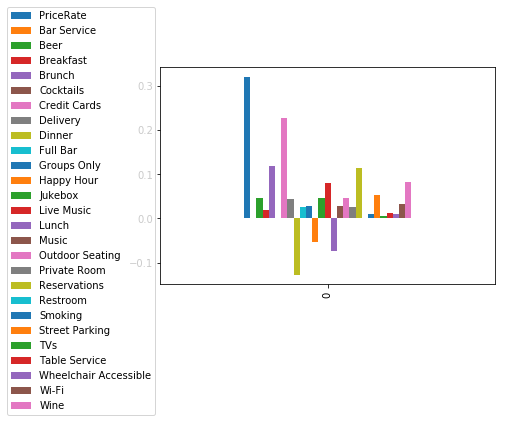

In [314]:
coeff_df = pd.DataFrame(coef_dict)
coeff_plot = coeff_df.plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

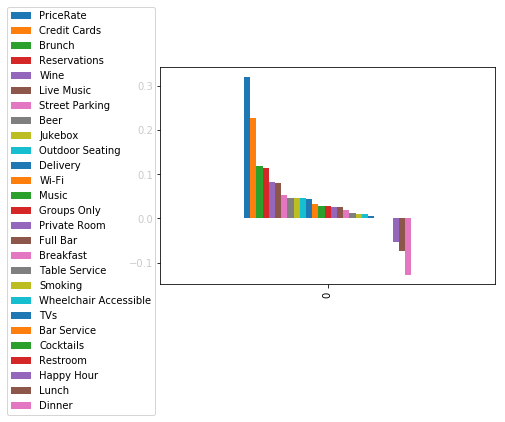

In [429]:
coeff_df = pd.DataFrame(OrderedDict(sorted(coef_dict.items(), key = itemgetter(1), reverse = True)))
coeff_plot = coeff_df.plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

As we see the three most important factors are the price, if we can pay with card and if we can have a reservation or not.
Based on the stats dinner/lunch and happy hours are contraversal for the ratings.

## Check coefficent for the number of likes

In [315]:
# Create linear regression object
regr_likes = linear_model.LinearRegression()
X_train = venue_df.drop(columns=['Rating', 'Likes', 'Price', 'Name', 'PostalCode'])
X_train['PriceRate'] = preprocessing.scale(X_train['PriceRate'])
regr_likes.fit(venue_df[['Likes']], X_train)
features = X_train.columns

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [316]:
coef_dict_likes = {}
for coef, feat in zip(regr_likes.coef_,features_likes):
    coef_dict_likes[feat] = coef
    print(feat + '\t' + str(coef[0]))

PriceRate	0.0017065989739780156
Bar Service	-2.280942543695887e-05
Beer	0.00038334138517119674
Breakfast	0.00031297188116355775
Brunch	0.0006536062570059806
Cocktails	-9.9181409822745e-05
Credit Cards	0.001198912442508371
Delivery	0.0006859685661085862
Dinner	-0.0006001969528753188
Full Bar	-0.0001485805462114107
Groups Only	7.192759465898787e-05
Happy Hour	9.649945050484954e-05
Jukebox	0.00010158240197400384
Live Music	0.0009901027527579361
Lunch	-0.00018691979322246925
Music	-6.377954682652438e-05
Outdoor Seating	0.0010342401403895874
Private Room	0.00046814238455608316
Reservations	0.0006259693047968097
Restroom	0.0
Smoking	0.00021029115299270142
Street Parking	0.0004387174594683152
TVs	0.00017419964331473627
Table Service	0.0002884255677873904
Wheelchair Accessible	0.00021029115299270142
Wi-Fi	0.0004607606108144468
Wine	0.00045087567504277493


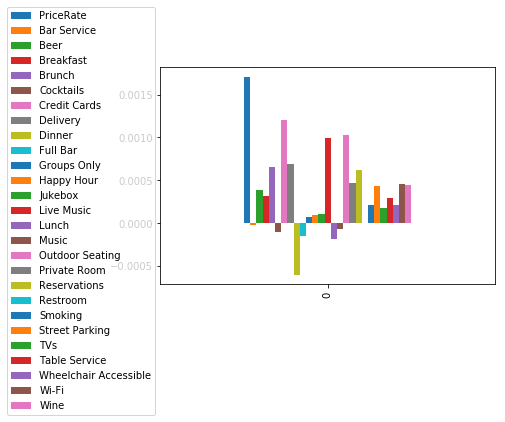

In [317]:
coeff_likes_df = pd.DataFrame(coef_dict_likes)
coeff_plot = coeff_likes_df.plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

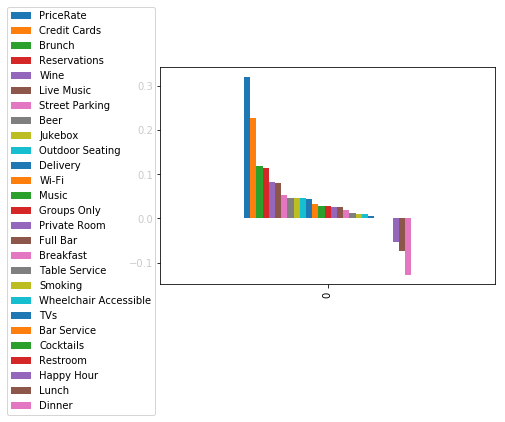

In [433]:
coeff_likes_df = pd.DataFrame(OrderedDict(sorted(coef_dict_likes.items(), key = itemgetter(1), reverse = True)))
coeff_plot = coeff_df.plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

It is not surprising that the number of likes are correlating with the ratings. So the price and the credit cards are the top 2 features.
However additional we have the live music and the outdoor seating as an important factor.
Dinner and lunches are still contraversal

## 4. Analyze Pub Neighborhoods

In [327]:
budapest_pubs_merged.drop_duplicates(inplace =True)
nearby_venues = getNearbyVenues(names=budapest_pubs_merged.index,
                                   latitudes=budapest_pubs_merged['Venue Latitude'],
                                   longitudes=budapest_pubs_merged['Venue Longitude'],
                                  radius = 500
                                  )

360 Bar
A Grund
Andersen 2
B.A.K. Hütte
Beer Point
Belga Söröző
Bistro Fine
Bohemia Söröző
Bohém Söröző
Borkonyha
Boutiq'Bar
Bujdosó Kert
Café Kör
Cech In Sörtár
Csak a jó sör!
Csak a jó sör!
Csősztorony Bisztró
Dagoba-bisztró
Dunaparti Matróz Kocsma
Déryné Bisztró
Faház Drinkbár
Fehér Nyúl Sörfőzde
Ferdinánd Monarchia Cseh Sörház
Fricska
Fricska
Game Up Pub
Guriga söröző
Gólya Közösségi Ház és Szövetkezeti Presszó
HaBár
Hedon
Hintaló Iszoda
Hivatal Kávézó
Hopaholic - In Hop We Trust
Horizont
Hunyadi Lakásbisztró
Hév Söröző
Jaromír '68 Cseh Sörpince
Kalicka Bistro
Kandalló Kézműves Pub
Kandalló Kézműves Pub
Kiadó Kocsma
Kisüzem
Kultúrpub
Kék Ló
Lakat Presszó
Lakatos Műhely
MONYO Brewing Co.
Medikus Kávézó
Mr&Mrs Columbo Pub
MÁK
MÁK
Márton Pince Söröző
Neked Csak Nyolc
OINOS WineBar&Bistrot
Ogre Bácsi
Ogre Bácsi
Patak
Pater Marcus Apátsági Söröző
Pocok Presszó
Pók Cafe
Pók Roulette Cafe
Pótkulcs
Refuge Bistro
Refuge Bistro
Retro Kert & Coffee
Rizmajer Kézműves Sörház
Rudolf borozó
STIKA

In [330]:
nearby_venues = nearby_venues.drop_duplicates()
nearby_venues

Id                        Neighborhood  \
0     533feb48498e1d3217065ddd                             360 Bar   
1     4b561c01f964a520d00028e3                             360 Bar   
2     5ad87c4c270ee7709230a865                             360 Bar   
3     4b293089f964a520b09a24e3                             360 Bar   
4     565b481c498efa946ce810e7                             360 Bar   
5     4ccd63867c2ff04ddc0f9f7e                             360 Bar   
6     4dcbd1421f6ea1401d473993                             360 Bar   
7     4bdace27c79cc92828c37fe9                             360 Bar   
8     4bb349854019a59321b637b8                             360 Bar   
9     542302d2498e7a1047927c54                             360 Bar   
10    513c69f919a9abf680c0653c                             360 Bar   
11    4bef0187d1b7d13a562ecdec                             360 Bar   
12    5264f1f211d21121ad4a8d14                             360 Bar   
13    4c093148ffb8c9b628756961                             360 Bar   
14    5051b04ae4b03eee83315e27                             360 Bar   
15    4b7692ecf964a5209e522ee3                             360 Bar   
16    4be97f96947820a1c511b6db                             360 Bar   
17    4c1b455355e4c9b607094923                             360 Bar   
18    4b2b4a6df964a5209ab524e3                             360 Bar   
19    5374ddf2498e43fccfbc5e89                             360 Bar   
20    4c97a5f872dd224ba763b691                             360 Bar   
21    4ffdbd96e4b0eb5cd04d3e74                             360 Bar   
22    521f72e811d2c5f04c9421f6                             360 Bar   
23    4c727b41d944224be1b80c29                             360 Bar   
24    4d40193c56f459416622b762                             360 Bar   
25    4baf97b5f964a5200c0e3ce3                             360 Bar   
26    59044f5fbb8d366fea4b66d2                             360 Bar   
27    4ca3008ef832a1cd49aa99e5                             360 Bar   
28    4b5b4a76f964a5200bf228e3                             360 Bar   
29    58a4c58798f8aa3b3507def8                             360 Bar   
...                        ...                                 ...   
5334  4cc0536a19ceb1f7f58228cd                     Wunder Sörművek   
5335  546a3a1a498eef23bd0959f2                     Wunder Sörművek   
5336  5683dea5498ec2f0d3854462                     Wunder Sörművek   
5337  4fd881b0e4b0a71e247cff1a                     Wunder Sörművek   
5338  4b782fcbf964a520b8ba2ee3                     Wunder Sörművek   
5339  4da9d8faa86e771ea715a66a                     Wunder Sörművek   
5340  4b940059f964a520486034e3  Zöld Angyal Söröző és Bowling Club   
5341  4edf24906da103028724c47b  Zöld Angyal Söröző és Bowling Club   
5342  4b719a50f964a52065502de3  Zöld Angyal Söröző és Bowling Club   
5343  4e382c44b61c5cb3c387d342  Zöld Angyal Söröző és Bowling Club   
5344  4da5b0351e726e496961620c  Zöld Angyal Söröző és Bowling Club   
5345  559d8f8d498e259c09389806  Zöld Angyal Söröző és Bowling Club   
5346  54929bc4498e25109b2520a4  Zöld Angyal Söröző és Bowling Club   
5347  54467de0498ed34e0176a94e  Zöld Angyal Söröző és Bowling Club   
5348  4cf68a4ac28df04d4b90cb15  Zöld Angyal Söröző és Bowling Club   
5349  4c0d2b41d64c0f478a4c265d  Zöld Angyal Söröző és Bowling Club   
5350  4bb73f351344b713f17b9e04  Zöld Angyal Söröző és Bowling Club   
5351  4db8667ea86ee4fa7d2266bf  Zöld Angyal Söröző és Bowling Club   
5352  4bbbd9dd51b89c7410d3862a  Zöld Angyal Söröző és Bowling Club   
5353  4da33dc1b3e7236a359c2e79  Zöld Angyal Söröző és Bowling Club   
5354  4c079db20e0a2d7fc48bed0c  Zöld Angyal Söröző és Bowling Club   
5355  4dfb3e23149557de37ac6dbc  Zöld Angyal Söröző és Bowling Club   
5356  4e301c4ab0fbdc2b6507d892  Zöld Angyal Söröző és Bowling Club   
5357  4c63e4ef4be3b713336aefe8  Zöld Angyal Söröző és Bowling Club   
5358  4d78ae87db7c5481633534f2  Zöld Angyal Söröző és Bowling Club   
5359  4e1796b9483b5cfa49c25d98  Zöld A

In [331]:
# one hot encoding
nearby_venue_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venue_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nearby_venue_onehot.columns[-1]] + list(nearby_venue_onehot.columns[:-1])
nearby_venue_onehot = nearby_venue_onehot[fixed_columns]

nearby_venue_onehot.head()

Neighborhood  American Restaurant  Arcade  Art Gallery  Art Museum  \
0      360 Bar                    0       0            0           0   
1      360 Bar                    0       0            0           0   
2      360 Bar                    0       0            0           0   
3      360 Bar                    0       0            0           0   
4      360 Bar                    0       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  BBQ Joint  \
0                    0                 0                   0          0   
1                    0                 0                   0          0   
2                    0                 0                   0          0   
3                    0                 0                   0          0   
4                    0                 0                   0          0   

   Bagel Shop  Baggage Locker  Bakery  Bar  Basketball Stadium  Beach Bar  \
0           0               0       0    0                   0          0   
1           0               0       0    0                   0          0   
2           0               0       0    0                   0          0   
3           0               0       0    0                   0          0   
4           0               0       0    0                   0          0   

   Beer Bar  Beer Garden  Beer Store  Bike Rental / Bike Share  Bistro  \
0         0            0           0                         0       0   
1         0            0           0                         0       0   
2         0            0           0                         0       0   
3         0            0           0                         0       0   
4         0            0           0                         0       0   

   Board Shop  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0           0              0          0                 0         0   
1           0              0          0                 0         0   
2           0              0          0                 0         0   
3           0              0          0                 0         0   
4           0              0          0                 0         1   

   Breakfast Spot  Brewery  Buffet  Building  Burger Joint  Burrito Place  \
0               0        0       0         0             0              0   
1               0        0       0         0             0              0   
2               0        0       0         0             0              0   
3               0        0       0         0             0              0   
4               0        0       0         0             0              0   

   Bus Station  Bus Stop  Butcher  Cafeteria  Café  Camera Store  Campground  \
0            0         0        0          0     0             0           0   
1            0         0        0          0     0             0           0   
2            0         0        0          0     1             0           0   
3            0         0        0          0     0             0           0   
4            0         0        0          0     0             0           0   

   Candy Store  Casino  Castle  Chinese Restaurant  Chocolate Shop  Church  \
0            0       0       0                   0               0       0   
1            0       0       0                   0               0       0   
2            0       0       0                   0               0       0   
3            0       0       0                   0               0       0   
4            0       0       0                   0               0       0   

   Clothing Store  Cocktail Bar  Coffee Shop  College Arts Building  \
0               0             0            0                      0   
1               0             0            0                      0   
2               0             0            0                      0   
3               0             0            0                      0   
4              

In [333]:
budapest_grouped = nearby_venue_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 10

for hood in budapest_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = budapest_grouped[budapest_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----360 Bar----
                         venue  freq
0                          Bar  0.08
1                      Theater  0.05
2                         Café  0.05
3                   Restaurant  0.05
4                  Pizza Place  0.03
5               Ice Cream Shop  0.03
6              Thai Restaurant  0.03
7  Eastern European Restaurant  0.03
8           Italian Restaurant  0.02
9         Hungarian Restaurant  0.02


----A Grund----
          venue  freq
0         Hotel  0.10
1           Bar  0.05
2           Pub  0.04
3  Burger Joint  0.04
4      Beer Bar  0.04
5          Café  0.04
6  Dessert Shop  0.03
7      Wine Bar  0.03
8   Coffee Shop  0.03
9   Supermarket  0.03


----Andersen 2----
                venue  freq
0               Hotel  0.05
1                Café  0.04
2        Burger Joint  0.04
3                 Pub  0.04
4            Beer Bar  0.04
5                 Bar  0.04
6          Restaurant  0.03
7   Electronics Store  0.03
8              Bakery  0.03
9  Italian Resta

           venue  freq
0   Tram Station  0.27
1    Yoga Studio  0.09
2            Bar  0.09
3   Burger Joint  0.09
4  Grocery Store  0.09
5           Park  0.09
6       Pharmacy  0.09
7       Bus Stop  0.09
8     Restaurant  0.09
9            Pub  0.00


----Gólya Közösségi Ház és Szövetkezeti Presszó----
                         venue  freq
0                        Hotel  0.12
1                          Pub  0.07
2                  Coffee Shop  0.05
3           Italian Restaurant  0.03
4                       Bakery  0.03
5  Eastern European Restaurant  0.03
6                 Dessert Shop  0.03
7         Gym / Fitness Center  0.03
8           Chinese Restaurant  0.03
9                   Restaurant  0.03


----HaBár----
                  venue  freq
0         Grocery Store  0.10
1           Coffee Shop  0.10
2                 Diner  0.07
3           Pizza Place  0.07
4   Fried Chicken Joint  0.07
5                  Café  0.03
6  Gym / Fitness Center  0.03
7                   Gym  0.03


                  venue  freq
0  Gym / Fitness Center  0.12
1                   Gym  0.08
2    Italian Restaurant  0.04
3            Restaurant  0.04
4    Chinese Restaurant  0.04
5            Smoke Shop  0.04
6          Skating Rink  0.04
7        Cosmetics Shop  0.04
8         Deli / Bodega  0.04
9          Dessert Shop  0.04


----Neked Csak Nyolc----
                venue  freq
0               Hotel  0.07
1                 Bar  0.04
2              Bakery  0.04
3        Dessert Shop  0.03
4         Coffee Shop  0.03
5            Beer Bar  0.03
6        Burger Joint  0.03
7  Italian Restaurant  0.03
8                 Pub  0.03
9            Wine Bar  0.03


----OINOS WineBar&Bistrot----
          venue  freq
0         Hotel  0.08
1   Coffee Shop  0.08
2     Gastropub  0.05
3         Plaza  0.05
4           Bar  0.05
5        Bakery  0.03
6    Beer Store  0.03
7    Theme Park  0.03
8  Burger Joint  0.03
9           Pub  0.03


----Ogre Bácsi----
                venue  freq
0         Co

                  venue  freq
0               Theater  0.06
1                   Bar  0.06
2    Italian Restaurant  0.04
3                  Café  0.04
4        Ice Cream Shop  0.03
5           Coffee Shop  0.03
6  Hungarian Restaurant  0.03
7   Indie Movie Theater  0.02
8       Thai Restaurant  0.02
9           Pizza Place  0.02


----Zöld Angyal Söröző és Bowling Club----
                  venue  freq
0                  Park  0.12
1                   Gym  0.08
2           Supermarket  0.04
3              Pharmacy  0.04
4  Gym / Fitness Center  0.04
5                  Café  0.04
6          Camera Store  0.04
7    Chinese Restaurant  0.04
8           Pizza Place  0.04
9                 Hotel  0.04




In [338]:
budapest_grouped = nearby_venue_onehot.groupby('Neighborhood').sum().reset_index()

Neighborhood  American Restaurant  Arcade  \
0                                       360 Bar                    1       0   
1                                       A Grund                    0       0   
2                                    Andersen 2                    0       0   
3                                  B.A.K. Hütte                    0       0   
4                                    Beer Point                    0       1   
5                                  Belga Söröző                    0       0   
6                                   Bistro Fine                    0       1   
7                                Bohemia Söröző                    0       0   
8                                  Bohém Söröző                    0       0   
9                                     Borkonyha                    0       0   
10                                   Boutiq'Bar                    0       1   
11                                 Bujdosó Kert                    0       0   
12                                     Café Kör                    0       0   
13                               Cech In Sörtár                    0       0   
14                               Csak a jó sör!                    0       1   
15                          Csősztorony Bisztró                    0       0   
16                               Dagoba-bisztró                    0       0   
17                      Dunaparti Matróz Kocsma                    0       0   
18                               Déryné Bisztró                    0       0   
19                               Faház Drinkbár                    0       0   
20                          Fehér Nyúl Sörfőzde                    0       1   
21              Ferdinánd Monarchia Cseh Sörház                    0       0   
22                                      Fricska                    0       1   
23                                  Game Up Pub                    0       0   
24                                Guriga söröző                    0       0   
25  Gólya Közösségi Ház és Szövetkezeti Presszó                    0       0   
26                                        HaBár                    0       0   
27                                        Hedon                    0       0   
28                               Hintaló Iszoda                    0       0   
29                               Hivatal Kávézó                    0       1   
..                                          ...                  ...     ...   
42                               Lakatos Műhely                    0       0   
43                            MONYO Brewing Co.                    0       0   
44                               Medikus Kávézó                    0       0   
45                           Mr&Mrs Columbo Pub                    0       0   
46                                          MÁK                    0       0   
47                          Márton Pince Söröző                    0       0   
48                             Neked Csak Nyolc                    0       0   
49                        OINOS WineBar&Bistrot                    0       0   
50                                   Ogre Bácsi                    1       0   
51                                        Patak                    0       0   
52                 Pater Marcus Apátsági Söröző                    0       0   
53                                Pocok Presszó                    0       0   
54                                     Pók Cafe                    0       0   
55                            Pók Roulette Cafe                    0       0   
56                                     Pótkulcs                    0       0   
57                                Refuge Bistro                    1       0   
58                          Retro Kert & Coffee                    0       0   
59                     Rizmajer Kézműves Sörház                    0       0   
60                                R

In [346]:
budapest_grouped = budapest_grouped.join(venue_df[['Name', 'Likes']].set_index('Name'), on='Neighborhood').fillna(venue_df['Likes'].mean())

In [350]:
# Create linear regression object
regr_neigh_likes = linear_model.LinearRegression()
X_train = budapest_grouped.drop(columns=['Neighborhood', 'Likes'])
regr_neigh_likes.fit(budapest_grouped[['Likes']], X_train)
features_neigh_likes = X_train.columns

In [351]:
coef_dict_neigh_likes = {}
for coef, feat in zip(regr_neigh_likes.coef_,features_neigh_likes):
    coef_dict_neigh_likes[feat] = coef
    print(feat + '\t' + str(coef[0]))

American Restaurant	-0.00011872139913884061
Arcade	0.0013353603156150155
Art Gallery	0.0006757260357611943
Art Museum	-0.0002264850787788512
Arts & Crafts Store	-0.0005211685516413307
Asian Restaurant	9.529895442922e-05
Athletics & Sports	-2.82734215759849e-20
BBQ Joint	0.0005631348293489716
Bagel Shop	-8.245109217301588e-05
Baggage Locker	0.0004639023345868383
Bakery	0.0012535733276540497
Bar	0.0049980993848300495
Basketball Stadium	-0.00020898848703829493
Beach Bar	4.4699321964924956e-05
Beer Bar	0.0031475729979518505
Beer Garden	-0.00011642257686635902
Beer Store	-0.0007640518959638857
Bike Rental / Bike Share	-1.1309368630393961e-20
Bistro	0.001180291982101267
Board Shop	-9.718909718659396e-05
Boat or Ferry	-5.5605956524366644e-05
Bookstore	0.0010304598548748387
Botanical Garden	-0.00031348273055744225
Boutique	0.00047570295558557865
Breakfast Spot	0.0017306044916637292
Brewery	-2.2618737260787922e-20
Buffet	0.00017815872611734378
Building	-9.519678455044303e-05
Burger Joint	0.0021

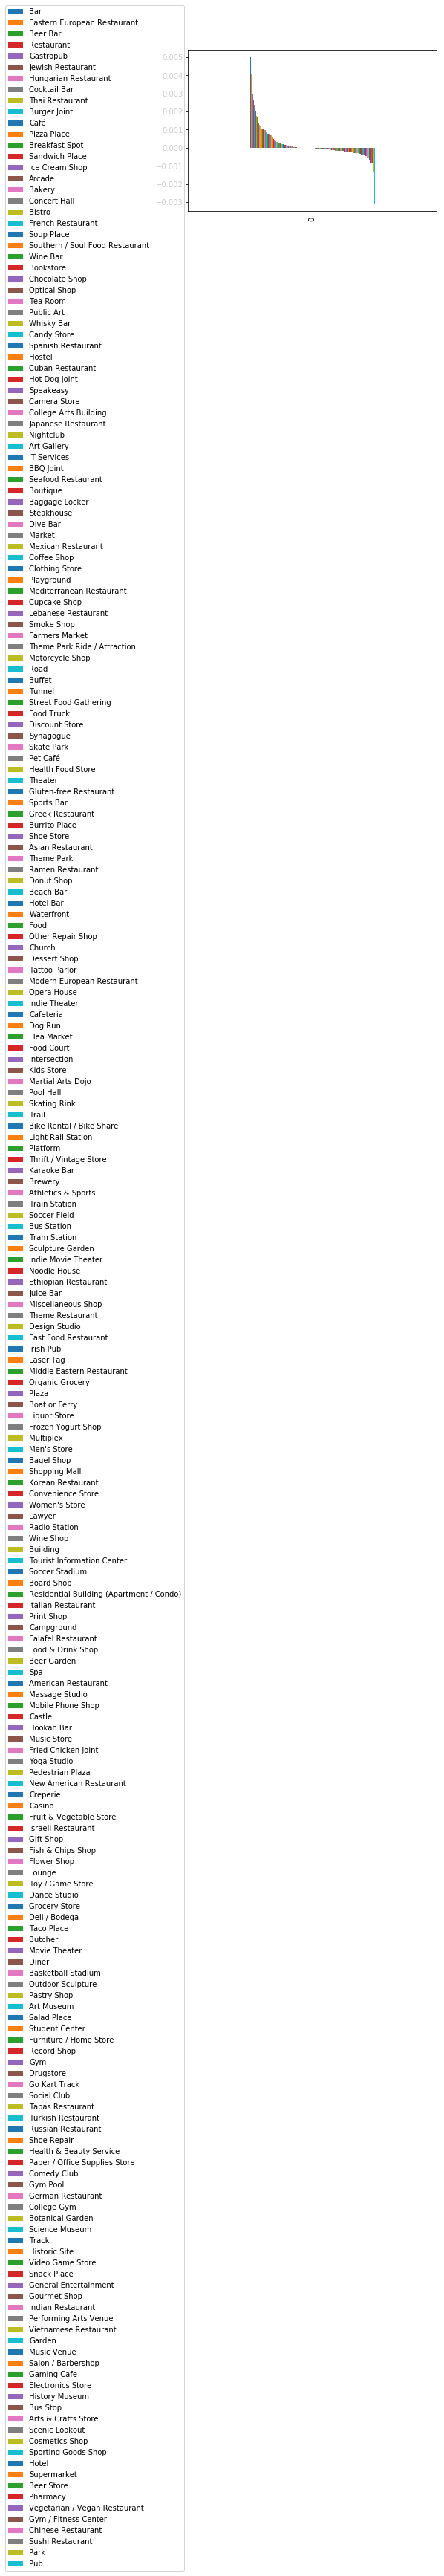

In [362]:
coeff_neigh_likes_df = pd.DataFrame(OrderedDict(sorted(coef_dict_neigh_likes.items(), key = itemgetter(1), reverse = True)))
coeff_plot = coeff_neigh_likes_df.plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

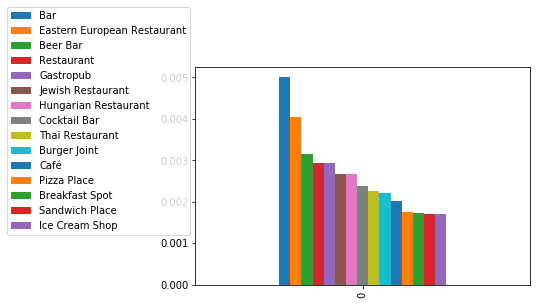

In [373]:
coeff_plot = coeff_neigh_likes_df.iloc[:,:15].plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

It seems it is good for the number of likes if we have bars close to our pubs. Restaurants also help, usually people go to pubs before or after they eat.

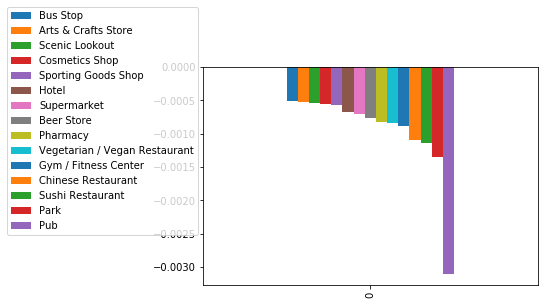

In [374]:
coeff_plot = coeff_neigh_likes_df.iloc[:,-15:].plot(kind='bar').legend(bbox_to_anchor=(0.0, 1.3))
coeff_plot

If there are other pubs nearby they might not help. It`s seems logical thus competitors might attract people from other places.

Not all restaurant affect positively the ratings, it seems chinese and sushi doesn`t go along well with beers.

Supermarket and beer stores are cheaper alternatives so they might decrease the popularity for the pub.

## 5. Analyzing possible locations

In [381]:
positive_cat = coeff_neigh_likes_df.iloc[:,:15].columns
negative_cat = coeff_neigh_likes_df.iloc[:,-15:].columns

In [379]:
budapest_venues

Id Neighborhood  Neighborhood Latitude  \
0     4bc9f998937ca59338c2a692   Budapest 1                47.4968   
1     4c1d22e0624b9c740ee61204   Budapest 1                47.4968   
2     4d908822788c5481e23866fd   Budapest 1                47.4968   
3     554b4a43498e8bba12723b77   Budapest 1                47.4968   
4     4c615b7bb6f3be9a52716173   Budapest 1                47.4968   
5     4c8a556b1dcd199cf464531b   Budapest 1                47.4968   
6     4c1d0c29b4e62d7f150ddc93   Budapest 1                47.4968   
7     4b28fb5ff964a520ea9624e3   Budapest 1                47.4968   
8     4bae5c9ff964a520f0a73be3   Budapest 1                47.4968   
9     4d46bd852e326ea83a21faa6   Budapest 1                47.4968   
10    4e30315f62e1fbac6112a69a   Budapest 1                47.4968   
11    4c24f4dff7ced13a74b6236d   Budapest 1                47.4968   
12    58666c2ed8b0ed6559f917a2   Budapest 1                47.4968   
13    53873551498e15240eb9a156   Budapest 1                47.4968   
14    4fe9cadfe4b0acc4d94052a4   Budapest 1                47.4968   
15    503e0102e4b0b133d42ecab8   Budapest 1                47.4968   
16    4e9da5ddb6348df6f736a98d   Budapest 1                47.4968   
17    4bd0fbf720cd99608a9b2e9e   Budapest 1                47.4968   
18    4c5fba3bb36eb713f8049ad2   Budapest 1                47.4968   
19    5220759911d2356f5427383c   Budapest 1                47.4968   
20    4c948ab172dd224be9ed9a91   Budapest 1                47.4968   
21    4b559b58f964a520d2e827e3   Budapest 1                47.4968   
22    4c9cde1b7c096dcb389cc5d1   Budapest 1                47.4968   
23    4d298eccc406721e6a537cb6   Budapest 1                47.4968   
24    4c90fbf151d9b1f72bae7c46   Budapest 1                47.4968   
25    4df7a6a8887712d325d0d5c4   Budapest 1                47.4968   
26    4bf42b4bff90c9b6faec5428   Budapest 1                47.4968   
27    4bdb02943904a5931d42489e   Budapest 1                47.4968   
28    4d52c5d39ffc236aafc830a7   Budapest 1                47.4968   
29    5059c340e4b082424ecc9822   Budapest 1                47.4968   
...                        ...          ...                    ...   
1077  4e8a9aab77c82799c20fadd3  Budapest 21                47.4244   
1078  4e0ef8efb0fb59de67db8f18  Budapest 22                47.4105   
1079  50a7ac3ce4b025015bac0012  Budapest 22                47.4105   
1080  4f35a0a5a17c4bfd28d25573  Budapest 22                47.4105   
1081  4fae8860e4b0815907e9babd  Budapest 22                47.4105   
1082  4fabd9d0e4b0eb9e949c96a7  Budapest 22                47.4105   
1083  5253d7ec0493709d674ad8dd  Budapest 22                47.4105   
1084  5058450be4b083cc6fc95395  Budapest 22                47.4105   
1085  51504ef0e4b01c6c27deff99  Budapest 22                47.4105   
1086  4d8cd0e8788c5481be8012fd  Budapest 22                47.4105   
1087  4e9db1d1be7beb6feffed9c4  Budapest 22                47.4105   
1088  4cfb8e1920fe370451c054f8  Budapest 22                47.4105   
1089  4f1aaabbe4b05c50e1c1a9a9  Budapest 22                47.4105   
1090  4c5014cd3a6f2d7f6169f076  Budapest 23                47.3940   
1091  4e8f162477c843122ce06bbf  Budapest 23                47.3940   
1092  4e71f2fd45dd2c5c1a6ae445  Budapest 23                47.3940   
1093  506d05eee4b0b4cf0d7a7a81  Budapest 23                47.3940   
1094  4fd75ac6e4b07c890631e9f8  Budapest 23                47.3940   
1095  500fcad7e4b0bff601b220e8  Budapest 23                47.3940   
1096  566fe15f498ee4fff040da34  Budapest 23                47.3940   
1097  4fa916a5e4b0bad89548b6f6  Budapest 23                47.3940   
1098  4eaf0b434fc6e99a5a9cf6ff  Budapest 23                47.3940   
1099  4d6ba1022bf054813e8fd1ed  Budapest 23                47.3940   
1100  4ead121be5e83bfaeb76c01b  Budapest 23                47.3940   
1101  4e3223f545ddcff0a7520073  Budapest 23                47.3940   
1102  4e4141b66284809c9f3cb2c4  Budape

In [406]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=14)

   
for lat, lng, label,cat in zip(budapest_venues['Venue Latitude'], budapest_venues['Venue Longitude'], budapest_venues['Venue'], budapest_venues['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    color = 'grey'
    fill = 'grey'
    op = 0
    if cat in positive_cat:
        color = 'green'
        fill = 'green'
        op = 0.2
    elif cat in negative_cat:
        color = 'red'
        fill = 'red'
        op = 0.2
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color=color,
        fill=True,
        fill_color=fill,
        fill_opacity=op,
        line_opacity=op,
        line_weight=0.01,
        parse_html=False).add_to(venues_map)  
    
# add markers to map
for lat, lng, label in zip(school_data['Latitude'], school_data['Longitude'], school_data['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.99,
        parse_html=False).add_to(venues_map)   
    


In [407]:
venues_map

In [417]:
positive_venues = budapest_venues[budapest_venues['Venue Category'].isin(positive_cat)]
negative_venues = budapest_venues[budapest_venues['Venue Category'].isin(negative_cat)]

In [427]:
from folium import plugins
heatmap = folium.Map(location=[latitude, longitude], zoom_start=14)
arr1 = positive_venues[['Venue Latitude', 'Venue Longitude']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr1, radius=25, gradient={.4: 'lime', .65: 'limegreen', 1: 'green'}))
arr2 = negative_venues[['Venue Latitude', 'Venue Longitude']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr2, radius=25, gradient={.4: 'pink', .65: 'red', 1: 'brown'}))

# add markers to map
for lat, lng, label in zip(school_data['Latitude'], school_data['Longitude'], school_data['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.99,
        parse_html=False).add_to(heatmap)  


In [428]:
heatmap

In [434]:
heatmap.save('heatmap.html')